In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

dataset_name = "syntetic"
split_ratios = (0.7, 0.15, 0.15)  # Train, Validation, Test
num_samples = 5000
num_classes = 2
embedding_dim = 1024

latent_dim = 2
noise_scale = 0.18
similarity_factor = 0.0035

root = '../..'
dataset_path = f"{root}/datasets/{dataset_name}"
dataset_embeddings = f"{dataset_path}_embeddings.npz"

In [2]:
assert sum(split_ratios) == 1.0, "Split ratios must sum to 1.0"
train_tot = int(num_samples * split_ratios[0])
val_tot = int(num_samples * split_ratios[1]) + train_tot

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 28 13:41:04 2025
@author: lport
"""

def generate_correlated_embeddings(
    num_samples: int,
    num_classes: int,
    embedding_dim: int,
    latent_dim: int = 64,
    noise_scale: float = 0.1,
    similarity_factor: float = 1.0
) -> tuple[np.ndarray, np.ndarray]:
    """
    Generates correlated embeddings organized by class.

    This function creates embeddings emb,  with the
    following property:
    1.  Class association: Each embedding belongs to one of C classes.

    Args:
        num_samples (int): The total number of embedding pairs to generate.
        num_classes (int): The number of distinct classes to model.
        embedding_dim (int): The dimensionality of the embeddings.
        latent_dim (int): The dimensionality of the shared latent space where
                          class concepts are defined.
        noise_scale (float): The standard deviation of the Gaussian noise added
                             to each embedding to create intra-class variance.
        similarity_factor (float): A factor to control how similar the class
                                   prototypes are in the latent space.
                                   Lower values make classes more similar.
    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing:
            - emb (np.ndarray): The matrix of text embeddings (shape: num_samples x text_embedding_dim).
            - labels (np.ndarray): An array of class labels for each pair (shape: num_samples).
    """
    print(f"Generating {num_samples} samples across {num_classes} classes...")

    # 1. Create class prototypes in a shared latent space
    # These vectors represent the "pure concept" of each class.
    np.random.seed(42) # for reproducibility
    latent_prototypes = np.random.randn(num_classes, latent_dim)

    # MODIFICA: Rendere i prototipi molto più simili tra loro
    base_prototype = np.random.randn(latent_dim)
    for i in range(num_classes):
        variation = latent_prototypes[i] * similarity_factor
        latent_prototypes[i] = base_prototype + variation

    # Normalize prototypes to have unit length for consistent similarity
    latent_prototypes /= np.linalg.norm(latent_prototypes, axis=1, keepdims=True)

    # 2. Create separate projection matrices for text and image spaces
    # These matrices will map the shared concepts into their respective, 
    #different vector spaces.
    projection = np.random.randn(latent_dim, embedding_dim)

    # 3. Project latent prototypes to create class centroids in each space
    class_centroids = latent_prototypes @ projection

    # 4. Generate individual samples for each class
    emb_list =[]
    labels_list =[]

    # Assign samples to classes
    sample_class_assignments = np.random.randint(0, num_classes, size=num_samples)

    for i in range(num_samples):
        class_idx = sample_class_assignments[i]

        # Get the centroid for the assigned class
        centroid = class_centroids[class_idx]

        # Add Gaussian noise to create variance within the class
        noise = np.random.normal(0, noise_scale, size=embedding_dim)

        # Create the final embedding by adding noise to the centroid
        final_embedding = centroid + noise

        emb_list.append(final_embedding)
        labels_list.append(class_idx)

    # Convert lists to numpy arrays
    emb = np.array(emb_list)
    labels = np.array(labels_list)
    # Normalize embeddings
    emb=normalize(emb)

    print("\nGeneration complete.")
    print(f"Shape of embeddings (emb): {emb.shape}")
    print(f"Shape of labels: {labels.shape}")

    return emb, labels

Generating 5000 samples across 2 classes...

Generation complete.
Shape of embeddings (emb): (5000, 1024)
Shape of labels: (5000,)


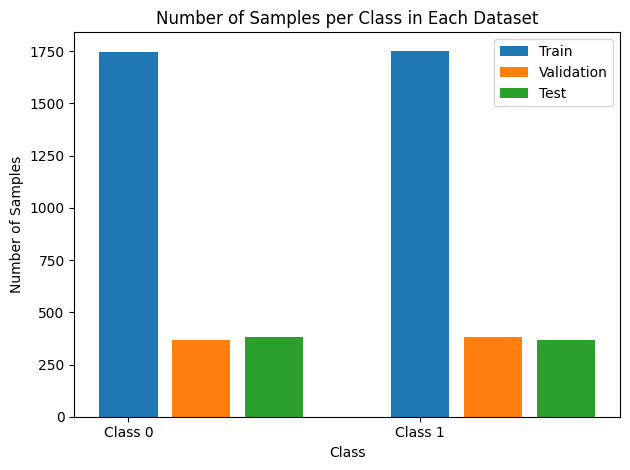

In [4]:
embeddings, predictions = generate_correlated_embeddings(
    num_samples=num_samples,
    num_classes=num_classes,
    embedding_dim=embedding_dim,
    latent_dim=latent_dim,
    noise_scale=noise_scale,
    similarity_factor=similarity_factor
)

indices = np.arange(num_samples)
np.random.shuffle(indices)
embeddings = embeddings[indices]
predictions = predictions[indices]

train_counts = np.bincount(predictions[:train_tot])
val_counts = np.bincount(predictions[train_tot:val_tot])
test_counts = np.bincount(predictions[val_tot:])

plt.figure()
x_labels = range(num_classes)
plt.bar(x_labels, train_counts, width=0.2, label='Train', align='center')
plt.bar([x + 0.25 for x in x_labels], val_counts, width=0.2, label='Validation', align='center')
plt.bar([x + 0.5 for x in x_labels], test_counts, width=0.2, label='Test', align='center')
plt.xticks(x_labels, [f"Class {i}" for i in x_labels])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class in Each Dataset')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
np.savez(
    dataset_embeddings,
    x_train=embeddings[:train_tot],
    y_train=predictions[:train_tot],
    x_val=embeddings[train_tot:val_tot],
    y_val=predictions[train_tot:val_tot],
    x_test=embeddings[val_tot:],
    y_test=predictions[val_tot:],
)

# --- Verification of the saved file ---
if os.path.exists(dataset_embeddings):
    loaded_data = np.load(dataset_embeddings)

    # Access arrays by the keys we provided during saving
    loaded_emb = loaded_data['x_train']
    loaded_labels = loaded_data['y_train']

    assert loaded_emb.shape == (train_tot, embedding_dim)
    assert loaded_labels.shape == (train_tot,)
else:
    print(f"Error: File '{dataset_embeddings}' was not found.")